In [31]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq

import muon as mu

import warnings
warnings.filterwarnings('ignore')


import seaborn as sns
import matplotlib.pyplot as plt
import plotnine as p9
from adjustText import adjust_text

from scipy.stats import ttest_rel

In [2]:
path = os.path.join('..','..', 'data', 'sma')
slides = pd.read_csv(os.path.join(path, "sma_meta.csv"), index_col=0).index

In [3]:
palette = {'Intact': '#1f77b4', 'Lesioned': '#a11838'}
views = {'receptor': 'Receptors', 'ct':'Cell types'}
view_palette = {"Receptors":"#566E3D", "Cell types":"#F7671A"}

## Visualize

In [22]:
target_metrics = pd.read_csv(os.path.join('results', "target_metrics.csv"), index_col=None)
interactions = pd.read_csv(os.path.join('results', "interactions.csv"), index_col=None)

In [74]:
# prettify
target_metrics['intra_group'] = target_metrics['intra_group'].str.capitalize()
target_metrics.rename(columns=views, inplace=True)
target_metrics.head()
interactions['view'] = interactions['view'].replace(views)

Keep only top 10 targets

In [15]:
targets = target_metrics.groupby(['target', 'intra_group']).agg({"gain_R2":'mean'}).sort_values("gain_R2", ascending=False).reset_index()
top_targets = targets['target'].unique()[0:10]
# as categorical with levels from targets
target_metrics['target'] = pd.Categorical(target_metrics['target'], categories=targets['target'].unique())
metrics = target_metrics[target_metrics['target'].isin(top_targets)]
metrics['target'] = pd.Categorical(metrics['target'], categories=top_targets)

F2 C)

In [16]:
data = metrics[metrics['target']=='Dopamine']
data['target'] = pd.Categorical(data['target'], categories=['Dopamine'])

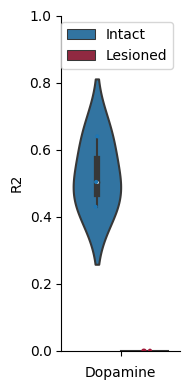

In [17]:
# Assuming 'filtered_data' is your DataFrame after filtering out the zero-only boxplots
plt.figure(figsize=(2, 4))  # Adjust the size to accommodate your number of categories

# Create the violin plot with an alpha of 0.5
sns.violinplot(x='target', y='gain_R2', hue='intra_group', data=data, palette=palette)

# Add the dots using stripplot
sns.stripplot(x='target', y='gain_R2', hue='intra_group', data=data, dodge=True, jitter=True, size=3, palette=palette)

# Customizing the plot
plt.xticks(rotation=90)
plt.xlabel('Dopamine')
plt.ylabel('R2')
# remove x-axis labels
plt.gca().set_xticklabels([])
plt.ylim(0, 1)
sns.despine()

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2])

plt.tight_layout()
plt.show()

F2 D)

In [18]:
targets = ['Dopamine'] # , '3-MT'
data = metrics[((metrics['target'].isin(targets)) & (metrics['intra_group']=="Intact"))]
data = data.melt(id_vars=['target', 'intra_group'], value_vars=views.values(), var_name='View', value_name='Contribution')
data['target'] = pd.Categorical(data['target'], categories=targets)

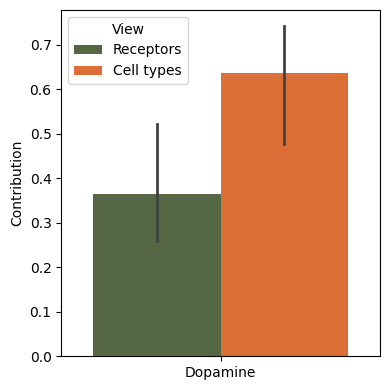

In [19]:
# unstacked barplot, with a median
plt.figure(figsize=(4, 4))
sns.barplot(data=data, x='target', y='Contribution', hue='View', palette=view_palette, ci=95, errwidth=2)
# plt.ylim(0, .8)
plt.title("")
plt.xlabel("")
plt.tight_layout()
plt.show()

F2 D)

In [76]:
dop_ints = interactions[interactions['target']=='Dopamine'].copy()
# predictors with highest importances
dop_ints = (dop_ints[dop_ints['intra_group']=='intact'].
              groupby(['target', 'predictor', 'view']).
              # agg by mean and count
              agg({"importances":'median', 'slide':'count'}).
              rename(columns={'slide':'count'}).
              reset_index()
              )

In [77]:
dop_ints['rank'] = dop_ints.groupby('target')['importances'].rank(ascending=False)

In [102]:
?adjust_text

Signature:
adjust_text(
    texts,
    x=None,
    y=None,
    objects=None,
    avoid_self=True,
    force_text: 'tuple[float, float]' = (0.1, 0.2),
    force_static: 'tuple[float, float]' = (0.1, 0.2),
    force_pull: 'tuple[float, float]' = (0.01, 0.01),
    force_explode: 'tuple[float, float]' = (0.01, 0.02),
    expand: 'tuple[float, float]' = (1.05, 1.1),
    explode_radius: 'str | float' = 'auto',
    ensure_inside_axes: 'bool' = True,
    expand_axes: 'bool' = False,
    only_move: 'dict' = {'text': 'xy', 'static': 'xy', 'explode': 'xy', 'pull': 'xy'},
    ax: 'matplotlib.axes.Axes | None' = None,
    min_arrow_len: 'float' = 5,
    time_lim: 'float | None' = None,
    iter_lim: 'int | None' = None,
    *args,
    **kwargs,
)
Docstring:
Iteratively adjusts the locations of texts.

Call adjust_text the very last, after all plotting (especially
anything that can change the axes limits) has been done. This is
because to move texts the function needs to use the dimensions of
the ax

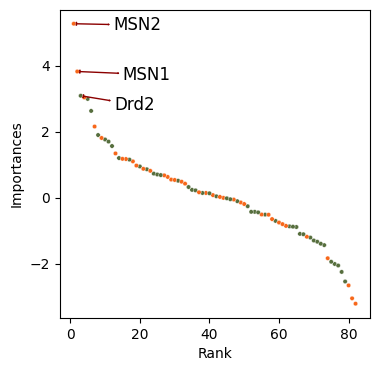

In [124]:
# Create a custom ax object
fig, ax = plt.subplots(figsize=(4, 4))

# Create the scatter plot on the custom ax
# Assuming view_palette is a palette defined earlier, otherwise replace with a seaborn palette
sns.scatterplot(x='rank', y='importances', palette=view_palette, hue='view', data=dop_ints, ax=ax, s=10)

# Label the top 3 interactions
top3 = dop_ints.nlargest(3, 'importances')
texts = []
for x, y, label in zip(top3['rank'], top3['importances'], top3['predictor']):
    # Offset the text by a certain amount to the right for clarity
    text = plt.text(x, y, label, fontsize='large', ha='left', va='center')
    texts.append(text)

# Use adjust_text to adjust the labels, avoiding overlap with points and other texts
adjust_text(texts,  
            force_pull=(-0.1, 0.2),
            arrowprops=dict(arrowstyle="<-[", color='darkred', lw=1))
# Add labels and a title
ax.set_xlabel('Rank')
ax.set_ylabel('Importances')

# Remove legend
legend = ax.legend_
if legend:
    legend.remove()

plt.show()


In [ ]:
def plot_lr_pairs(H, fct, label_fun, method='average', filename=None):
    lr_pairs = H[fct].reset_index()
    lr_pairs['rank'] = lr_pairs[fct].rank(ascending=False, method=method)
    lr_pairs['name'] = lr_pairs.apply(label_fun, axis=1)

    # Create scatter plot
    fig, ax = plt.subplots(figsize=(6, 6))  # Increased figure size for better readability
    ax.scatter(lr_pairs['rank'], lr_pairs[fct], s=30, c='black')

    # Add text labels only for non-None labels
    texts = []
    for i, row in lr_pairs.iterrows():
        if row['name']:  # only add a text label if the name is not None
            texts.append(ax.text(row['rank'], row[fct], row['name'], fontsize=14))  # Increased font size

    # Adjust text to avoid overlap with improved parameters
    adjust_text(texts, expand_points=(2, 1), arrowprops=dict(arrowstyle='->', color='darkred'), force_text=(0.5, 1))

    # Set labels and title with larger font size
    ax.set_xlabel('Rank', fontsize=15)
    ax.set_ylabel(f'{fct} loadings', fontsize=15)
    plt.xticks(fontsize=14, rotation=90)  # Rotate and increase font size of x-axis labels
    plt.yticks(fontsize=14)  # Increase font size of y-axis labels
    plt.tight_layout()  # Adjust the padding between and around subplots
    
    
    if filename:
        plt.savefig(filename, bbox_inches='tight')

    plt.show()

SF A)

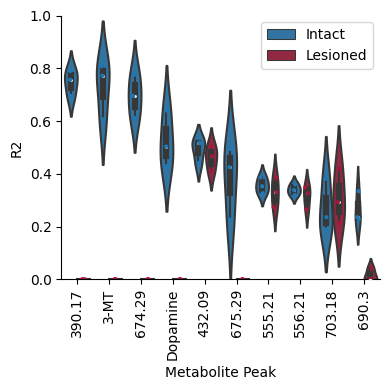

In [ ]:
# Assuming 'filtered_data' is your DataFrame after filtering out the zero-only boxplots
plt.figure(figsize=(4, 4))  # Adjust the size to accommodate your number of categories

# Create the violin plot with an alpha of 0.5
sns.violinplot(x='target', y='gain_R2', hue='intra_group', data=metrics, palette=palette)

# Add the dots using stripplot
sns.stripplot(x='target', y='gain_R2', hue='intra_group', data=metrics, dodge=True, jitter=True, size=3, palette=palette)

# Customizing the plot
plt.xticks(rotation=90)
plt.xlabel('Metabolite Peak')
plt.ylabel('R2')
plt.ylim(0, 1)
sns.despine()

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2])


# Show the plot
plt.tight_layout()
plt.show()

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


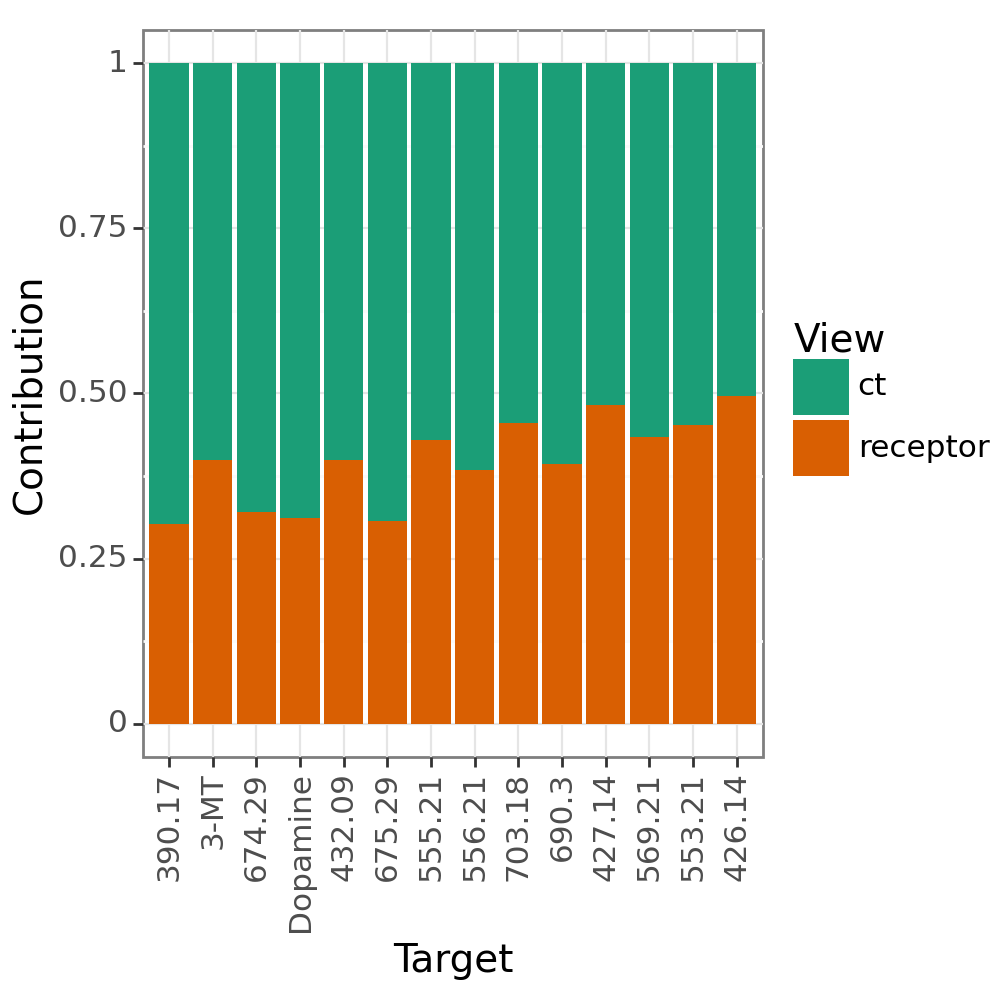

<Figure Size: (500 x 500)>

In [ ]:
li.pl.contributions(target_metrics=target_metrics, 
                    filter_fun=lambda x: bool((x['target'] in top_targets) * (x['intra_group']=='intact')),
                    view_names=['receptor', 'ct'],
                    aggregate_fun='median',
                    figure_size=(5, 5)
                    )

In [ ]:
dop_ints = interactions[interactions['target']=='Dopamine'].copy()
# predictors with highest importances
predictors = (dop_ints[dop_ints['intra_group']=='intact'].
              groupby(['target', 'predictor']).
              # agg by mean and count
              agg({"importances":'median', 'level_0':'count'}).
              rename(columns={'level_0':'count'}).
              reset_index()
              )
# detected in all 3 samples, NOTE: filter to top 10 predictors
predictors = predictors[predictors['count']==3].sort_values('importances', ascending=False)

In [ ]:
predictors.head(3)

,target,predictor,importances,count
50,Dopamine,MSN2,5.271267,3
49,Dopamine,MSN1,3.823600,3
18,Dopamine,Drd2,3.087695,3


In [ ]:
# rename to an abbreviation
dop_ints.loc[dop_ints['predictor']=='Subventricular zone radial glia-like cells', 'predictor'] = 'SVZGC'
dop_ints.loc[dop_ints['predictor']=='Oligodendrocytes', 'predictor'] = 'Oligo'
dop_ints = dop_ints[dop_ints['predictor'].isin(predictors['predictor'])].copy()

In [ ]:
pvals = pd.DataFrame(columns=['predictor', 'pval'])
for predictor in dop_ints['predictor'].unique():
    interaction_msk = ((interactions['predictor']==predictor) & (interactions['target']=='Dopamine'))
    group1 = interactions[interaction_msk & (interactions['intra_group']=='intact')].copy()
    group2 = interactions[interaction_msk & (interactions['intra_group']=='lesioned')].copy()
    tt = ttest_rel(group1['importances'], group2['importances'], alternative='greater')
    pvals.loc[len(pvals)] = [predictor, tt.pvalue]

In [ ]:
pvals['fdr'] = dc.p_adjust_fdr(pvals['pval'].values)

In [ ]:
pvals.set_index('predictor', inplace=True)

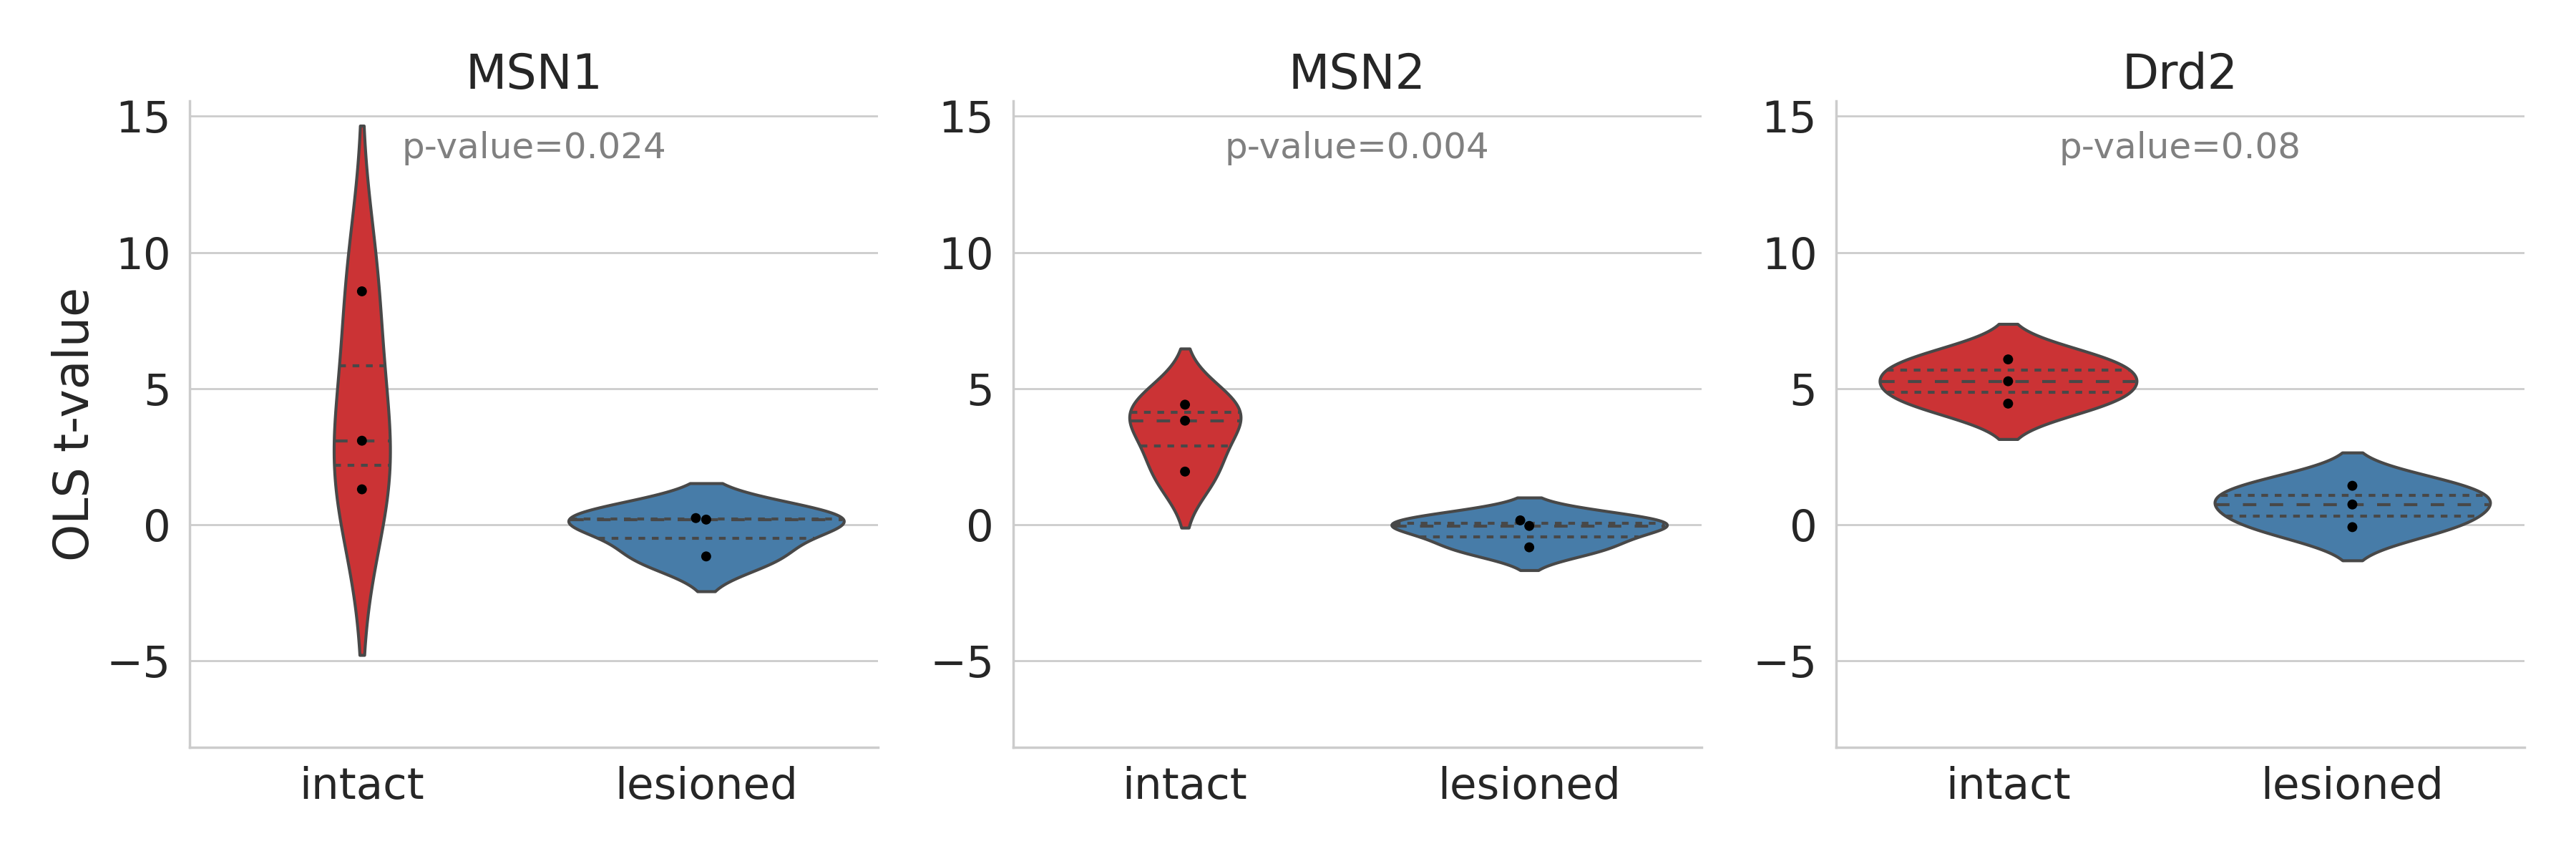

In [ ]:
preds = ["MSN1", "MSN2", "Drd2"]
df = dop_ints[dop_ints['predictor'].isin(preds)]

# Set the style to seaborn for better aesthetics
sns.set(style="whitegrid", font_scale=2)

# Create subplots with facets
g = sns.FacetGrid(df, col="predictor", col_wrap=3, height=6, sharey=False, ylim=(df['importances'].min() - 7, df['importances'].max() + 7))
g.map_dataframe(sns.violinplot, x='intra_group', y='importances', split=True, inner='quart', alpha=0.6, color='intra_group', palette='Set1')
g.map_dataframe(sns.swarmplot, x='intra_group', y='importances', color='black')

# Add text for t-test result
for pred, ax in zip(preds, g.axes.flat):
    pval_label = f'p-value={round(pvals.loc[pred]["pval"], 3)}'
    ax.text(0.5, 0.9, pval_label, ha='center', va='bottom', transform=ax.transAxes, color='gray', size=18)
    ax.set_title(pred)

# Set labels and title
g.set_axis_labels("Predictor", "OLS t-value")

# Remove x axis labels
plt.setp(g.axes.flat, xlabel='')

# Adjust layout
plt.tight_layout()

plt.savefig("dopamine.pdf")
plt.show()


### 2x3 dop + labels; drd: lr cats, pvals; MSN2: score, cats, pvals

In [ ]:
### LOAD DAta

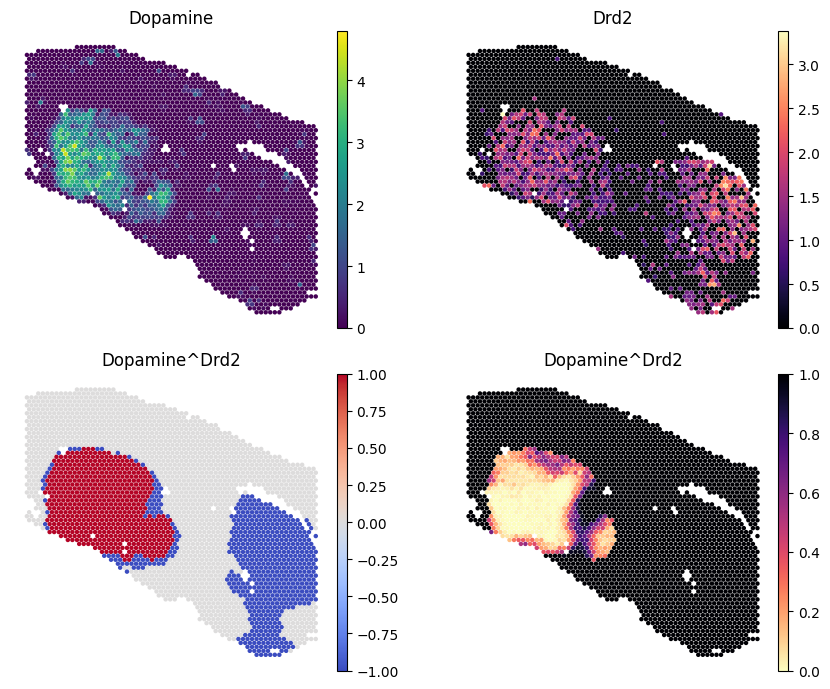

In [5]:

fig, ax = plt.subplots(2, 2, figsize=(9, 7))

sq.pl.spatial_scatter(mdata.mod['msi'], color=['Dopamine'], size=1.5, cmap="viridis", ax=ax[0, 0], img=False, frameon=False)
sq.pl.spatial_scatter(mdata.mod['rna'], color=['Drd2'], size=1.5, cmap='magma', ax=ax[0, 1], img=False, frameon=False)
sq.pl.spatial_scatter(mdata.mod['lr'], color=['Dopamine^Drd2'], layer='cats', size=1.5, cmap='coolwarm', vmax=1, vmin=-1, ax=ax[1,0], img=False, frameon=False)
sq.pl.spatial_scatter(mdata.mod['lr'], color=['Dopamine^Drd2'], layer='pvals', size=1.5, cmap='magma_r', vmax=1, ax=ax[1,1], img=False, frameon=False)

fig.tight_layout()
plt.show()

# fig.savefig("figures/dopamine_drd2.pdf")

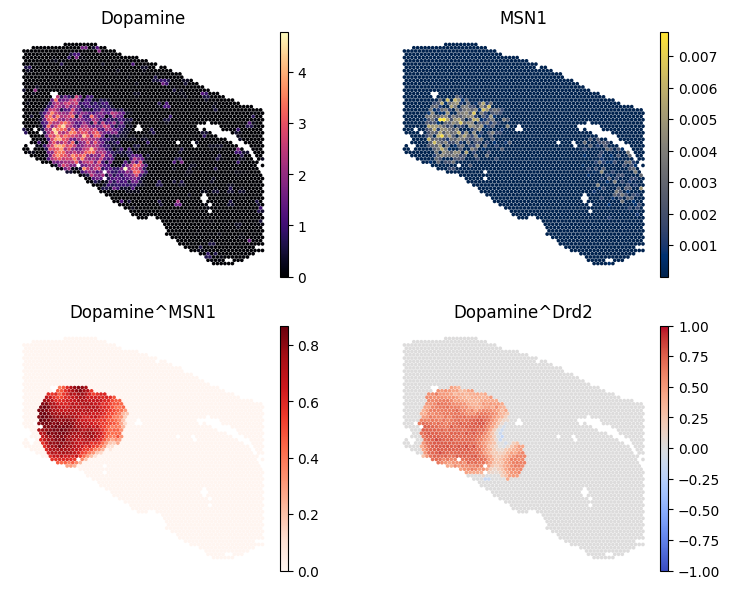

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(9, 7))

sq.pl.spatial_scatter(mdata.mod['msi'], color=['Dopamine'], size=1.5, cmap='magma', ax=ax[0,0], frameon=False, img=False)
sq.pl.spatial_scatter(mdata.mod['deconv'], color=['MSN1'], size=1.5, cmap='cividis', ax=ax[0,1], frameon=False, img=False)
sq.pl.spatial_scatter(mdata.mod['msi_ct'], color=['Dopamine^MSN1'], size=1.5, cmap='Reds', ax=ax[1,0], frameon=False, img=False)
sq.pl.spatial_scatter(mdata.mod['lr'], color=['Dopamine^Drd2'], size=1.5, cmap='coolwarm', vmax=1, vmin=-1, ax=ax[1,1], frameon=False, img=False)
plt.show()

# fig.savefig(os.path.join('..' '..', "figures', 'dopamine_msn.pdf"))